In [ ]:
import numpy as np
import pandas as pd
import itertools
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from joblib import dump, load
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import CIFAR10, GTSRB, MNIST, FashionMNIST, CIFAR100, ImageFolder, SVHN
import torchvision.transforms as transforms
from sklearn import metrics
from networks import GtsrbAnnModel, MnistAnnModel, Cifar10AnnModel, ResNet18_32x32
from PIL import Image
from IPython.display import clear_output

import torchbnn as bnn
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

from methods_collection.utils.metrics_utils import auc_and_fpr_recall, acc
from methods_collection.dice.RuntimeMonitor import DiceMonitor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
config = {}
config['resnet'] = {'p': 90, 'threshold': 6.2}
config['cifar10'] = {'p': 50.0, 'threshold': 30.0}
config['gtsrb'] = {'p': 20, 'threshold': 6.0}

## Aux functions

In [ ]:
class Convert:
    def __init__(self, mode='RGB'):
        self.mode = mode

    def __call__(self, image):
        return image.convert(self.mode)

In [ ]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [ ]:
def compute_all_metrics(result_in, result_out, odin_th):
  conf_in, pred_in, lab_in = result_in
  conf_out, pred_out, lab_out = result_out
  lab_out = -1 * np.ones_like(lab_out)

  conf = np.concatenate([conf_in, conf_out])
  y_pred = np.concatenate([pred_in, pred_out])
  y_true = np.concatenate([lab_in, lab_out])

  recall = 0.95
  auroc, aupr_in, aupr_out, fpr = auc_and_fpr_recall(conf, y_true, recall)

  accuracy = acc(y_pred, y_true)

  lab_true = np.zeros_like(y_true)
  lab_true[y_true == -1] = 1
  lab_pred = np.zeros_like(y_true)
  lab_pred[conf<=odin_th] = 1

  tn, fp, fn, tp = confusion_matrix(lab_true, lab_pred).ravel()
  results = [np.round(auroc*100, 2), np.round(fpr*100, 2), np.round(aupr_out*100, 2), tn, fp, fn, tp]
  return results

In [ ]:
def evaluate_ood(model, ood_monitor, dataset_name, train=False):
  batch_size = 128
  dataset, test_dataset, transform = load_dataset(dataset_name)

  set_loader = DataLoader(dataset, batch_size, num_workers=2) if train else DataLoader(test_dataset, batch_size, num_workers=2)

  all_pred = []
  all_conf = []
  all_lab = []
  valCorrect = 0
  for data, target in set_loader:
        (x, y) = (data.to(device), target.to(device))
        x.requires_grad = True
        pred_values, conf = ood_monitor.process_input(model, x)

        valCorrect += torch.sum(pred_values == y).cpu()

        all_pred += pred_values.detach().cpu().numpy().tolist()
        all_conf += conf.detach().cpu().numpy().tolist()
        all_lab += y.detach().cpu().numpy().tolist()
  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  print(f'Accuracy: {np.round(valCorrect * 100 / len(set_loader.dataset), 2)}')

  return all_conf, all_pred, all_lab

In [ ]:
def evaluate_ood_gaussian(model, ood_monitor, dataset_name, data_size=10000):
  dataset, test_dataset, transform = load_dataset(dataset_name)
  batch_size = 100
  num_batches = int(data_size/batch_size)

  all_conf = []
  all_pred = []
  all_lab = []
  for i in range(num_batches):
    np_images = np.asarray(np.uint8(np.random.rand(batch_size, 32, 32, 3) * 255))
    pil_images_tr = [transform(Image.fromarray(im, 'RGB')) for im in np_images]
    gaussian_noise = torch.stack(pil_images_tr).to(device)
    gaussian_noise.requires_grad = True
    pred_values, conf = ood_monitor.process_input(model, gaussian_noise)
    all_pred += pred_values.detach().cpu().numpy().tolist()
    all_conf += conf.detach().cpu().numpy().tolist()
    all_lab += (-1 * np.ones(batch_size)).tolist()


  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  return all_conf, all_pred, all_lab

## Dataset loading

In [ ]:
def load_dataset(DATASET_TO_USE):
  dataset = None
  test_dataset = None
  transform = transforms.Compose([
      Convert('RGB'),
      transforms.Resize([32, 32], interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
      ])
  if DATASET_TO_USE == 'CIFAR10':
    root_dataset_path = './datasets/cifar10/'
    dataset = CIFAR10(root=root_dataset_path, download=False, transform=transform)
    test_dataset = CIFAR10(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'GTSRB':
    root_dataset_path = './datasets/'
    dataset = GTSRB(root='./datasets/', download=False, split='train', transform=transform)
    test_dataset = GTSRB(root='./datasets/', download=False, split='test',transform=transform)
  if DATASET_TO_USE == 'MNIST':
    root_dataset_path = './datasets/mnist/'
    dataset = MNIST(root=root_dataset_path, download=False, transform=transform)
    test_dataset = MNIST(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'FashionMNIST':
    root_dataset_path = './datasets/fashion_mnist/'
    dataset = FashionMNIST(root=root_dataset_path, train=True, download=False, transform=transform)
    test_dataset = FashionMNIST(root=root_dataset_path, train=False, download=False, transform=transform)
  if DATASET_TO_USE == 'CIFAR100':
    root_dataset_path = './datasets/cifar100/'
    dataset = CIFAR100(root=root_dataset_path, download=True, transform=transform)
    test_dataset = CIFAR100(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'IMAGENET':
    dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
    test_dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
  if DATASET_TO_USE == 'SVHN':
    root_dataset_path = './datasets/svhn/'
    dataset = SVHN(root=root_dataset_path, split='train', download=True, transform=transform)
    test_dataset = SVHN(root=root_dataset_path, split='test', download=True, transform=transform)

  return dataset, test_dataset, transform

## Model loading

In [ ]:
cifar10_model = Cifar10AnnModel().to(device)
cifar10_model.load_state_dict(torch.load('./models/cifar_10_ann_model/model/model.pth'))
cifar10_model.eval()

resnet = ResNet18_32x32(num_classes=10).to(device)
resnet.load_state_dict(
    torch.load('./models/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt', map_location=torch.device('cpu'))
)
resnet.eval()

gtsrb_model = GtsrbAnnModel().to(device)
gtsrb_model.load_state_dict(torch.load('./models/gtsrb_ann_model/model/model.pth'))
gtsrb_model.eval()

GtsrbAnnModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear1): Linear(in_features=500, out_features=240, bias=True)
  (batchnorm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=240, out_features=84, bias=True)
  (batchnorm2): LayerNorm((84,), eps=1e-05, elementwise_affine=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=84, out_features=43, bias=True)
  (activation3): Softmax(dim=1)
)

## Monitor tuning

In [ ]:
dataset, test_dataset, _ = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

cifar10_dice_monitor = DiceMonitor(0, device)
cifar10_dice_monitor.setup(gtsrb_model, train_loader)

In [ ]:
# search grid for noise value used in mahalanobis paper's code
p_values = [0.0, 10, 20, 30, 50, 70, 90, 100]

best_auroc = None
best_p_value = None
for p in p_values:
  print(f'Evaluating noise: {p}')
  cifar10_dice_monitor.p = p
  all_conf_in, all_pred, _ = evaluate_ood(gtsrb_model, cifar10_dice_monitor, 'GTSRB', True)
  y_in = np.zeros(all_conf_in.shape)

  all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(gtsrb_model, cifar10_dice_monitor, 'GTSRB', 50000)
  y_out = np.ones(all_conf_out.shape)

  all_conf = np.concatenate((all_conf_in, all_conf_out), axis=None)
  y = np.concatenate((y_in, y_out), axis=None)

  auroc = roc_auc_score(y_true = y, y_score = all_conf)
  if best_auroc is None or auroc > best_auroc:
      best_p_value = p
      best_auroc = auroc
      print('best')
  print(auroc)
  print('--------------')
print(best_p_value)

Evaluating noise: 0.0
Accuracy: 91.26000213623047
best
0.019717359789844166
--------------
Evaluating noise: 10
Accuracy: 91.26000213623047
best
0.020039292509372846
--------------
Evaluating noise: 20
Accuracy: 91.26000213623047
best
0.02019328572521615
--------------
Evaluating noise: 30
Accuracy: 91.26000213623047
0.02006428422045959
--------------
Evaluating noise: 50
Accuracy: 91.26000213623047
0.01985446402611645
--------------
Evaluating noise: 70
Accuracy: 91.26000213623047
0.019923698385574742
--------------
Evaluating noise: 90
Accuracy: 91.26000213623047
0.019740729934453825
--------------
Evaluating noise: 100
Accuracy: 91.26000213623047
0.020064187303935322
--------------
20


In [ ]:
print(best_auroc)
print(best_p_value)
dataset, test_dataset, _ = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

config['gtsrb']['p'] = 20

cifar10_dice_monitor = DiceMonitor(config['gtsrb']['p'], device)
cifar10_dice_monitor.setup(gtsrb_model, train_loader)

0.02019328572521615
20


In [ ]:
all_conf_in, all_pred_in, _ = evaluate_ood(gtsrb_model, cifar10_dice_monitor, 'GTSRB', True)

Accuracy: 90.73999786376953


37816


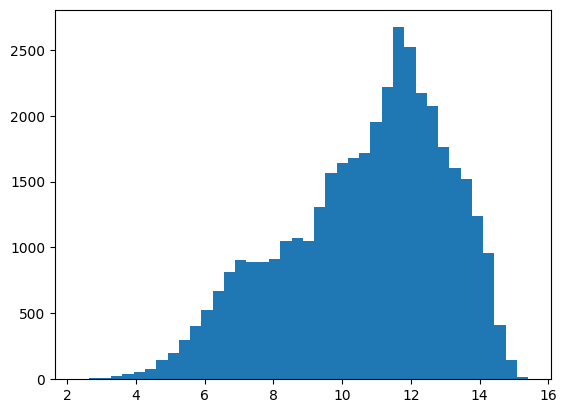

In [ ]:
config['gtsrb']['threshold'] = 6.0

print(np.sum(all_conf_in>config['gtsrb']['threshold']))
plt.hist(all_conf_in, bins = 40)
plt.show()

In [ ]:
all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(gtsrb_model, cifar10_dice_monitor, 'GTSRB', 50000)

35016


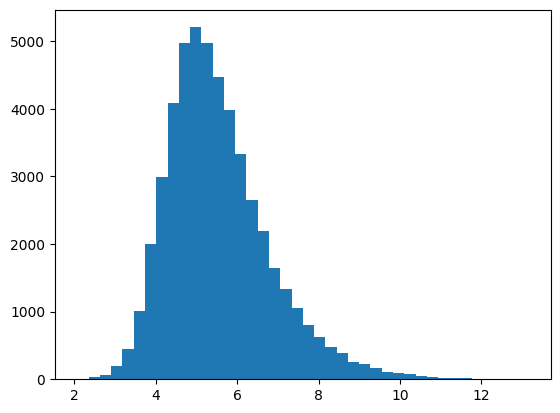

In [ ]:
print(np.sum(all_conf_out<=config['gtsrb']['threshold']))
plt.hist(all_conf_out, bins = 40)
plt.show()

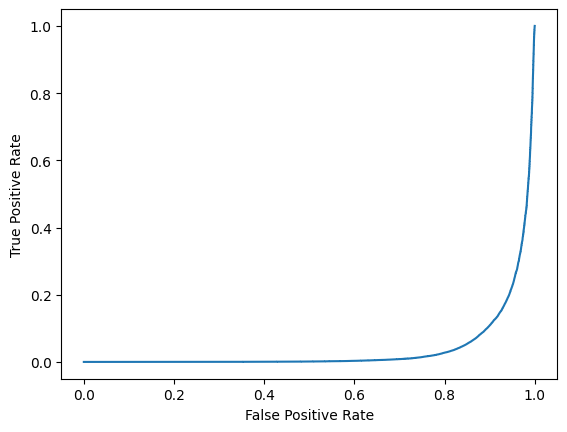

In [ ]:
y_in = np.zeros(all_conf_in.shape)
y_out = np.ones(all_conf_out.shape)
all_conf = np.concatenate((all_conf_in, all_conf_out), axis=None)
y = np.concatenate((y_in, y_out), axis=None)
fpr_list, tpr_list, thresholds = roc_curve(y_true = y, y_score = all_conf)

plot_roc_curve(y, all_conf)

## Evaluation

ResNet

In [ ]:
dataset, test_dataset, _ = load_dataset('CIFAR10')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_resnet = {}
resnet_dice_monitor = DiceMonitor(config['resnet']['p'], device)
resnet_dice_monitor.setup(resnet, train_loader)

In [ ]:
results_resnet['in'] = evaluate_ood(resnet, resnet_dice_monitor, 'CIFAR10')
results_resnet['out_cifar100'] = evaluate_ood(resnet, resnet_dice_monitor, 'CIFAR100')
results_resnet['out_image_net'] = evaluate_ood(resnet, resnet_dice_monitor, 'IMAGENET')
results_resnet['out_svhn'] = evaluate_ood(resnet, resnet_dice_monitor, 'SVHN')

Accuracy: 94.91000366210938
Files already downloaded and verified
Accuracy: 1.149999976158142
Accuracy: 13.960000038146973
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 10.010000228881836


In [ ]:
result1 = compute_all_metrics(results_resnet['in'], results_resnet['out_cifar100'], config['resnet']['threshold'])
result2 = compute_all_metrics(results_resnet['in'], results_resnet['out_image_net'], config['resnet']['threshold'])
result3 = compute_all_metrics(results_resnet['in'], results_resnet['out_svhn'], config['resnet']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string +='$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$76.05$ & $84.68$ & $77.44$ & $8225$ & $1775$ & $4243$ & $5757$ & 
$84.54$ & $62.61$ & $84.19$ & $8225$ & $1775$ & $2841$ & $7159$ & 
$88.08$ & $56.1$ & $94.62$ & $8225$ & $1775$ & $5353$ & $20679$ & 


Cifar10AnnModel

In [ ]:
dataset, test_dataset, _ = load_dataset('CIFAR10')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_cifar10 = {}
cifar10_dice_monitor = DiceMonitor(config['cifar10']['p'], device)
cifar10_dice_monitor.setup(cifar10_model, train_loader)

In [ ]:
results_cifar10['in'] = evaluate_ood(cifar10_model, cifar10_dice_monitor, 'CIFAR10')
results_cifar10['out_cifar100'] = evaluate_ood(cifar10_model, cifar10_dice_monitor, 'CIFAR100')
results_cifar10['out_image_net'] = evaluate_ood(cifar10_model, cifar10_dice_monitor, 'IMAGENET')
results_cifar10['out_svhn'] = evaluate_ood(cifar10_model, cifar10_dice_monitor, 'SVHN')

Accuracy: 69.75
Files already downloaded and verified
Accuracy: 1.0399999618530273
Accuracy: 8.369999885559082
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 11.289999961853027


In [ ]:
result1 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_cifar100'], config['cifar10']['threshold'])
result2 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_image_net'], config['cifar10']['threshold'])
result3 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_svhn'], config['cifar10']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$69.09$ & $74.96$ & $64.48$ & $8052$ & $1948$ & $6045$ & $3955$ & 
$60.62$ & $92.47$ & $58.85$ & $8052$ & $1948$ & $6936$ & $3064$ & 
$75.24$ & $56.5$ & $84.12$ & $8052$ & $1948$ & $14074$ & $11958$ & 


GtsrbAnnModel

In [ ]:
dataset, test_dataset, _ = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_gtsrb = {}
gtsrb_dice_monitor = DiceMonitor(config['gtsrb']['p'], device)
gtsrb_dice_monitor.setup(gtsrb_model, train_loader)

In [ ]:
results_gtsrb['in'] = evaluate_ood(gtsrb_model, gtsrb_dice_monitor, 'GTSRB')
results_gtsrb['out_cifar100'] = evaluate_ood(gtsrb_model, gtsrb_dice_monitor, 'CIFAR100')
results_gtsrb['out_image_net'] = evaluate_ood(gtsrb_model, gtsrb_dice_monitor, 'IMAGENET')
results_gtsrb['out_svhn'] = evaluate_ood(gtsrb_model, gtsrb_dice_monitor, 'SVHN')

Accuracy: 86.66999816894531
Files already downloaded and verified
Accuracy: 0.8199999928474426
Accuracy: 0.0
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 2.569999933242798


In [ ]:
result1 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_cifar100'], config['gtsrb']['threshold'])
result2 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_image_net'], config['gtsrb']['threshold'])
result3 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_svhn'], config['gtsrb']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$91.48$ & $28.31$ & $86.53$ & $11788$ & $842$ & $3987$ & $6013$ & 
$91.35$ & $27.7$ & $86.06$ & $11788$ & $842$ & $4098$ & $5902$ & 
$93.34$ & $22.04$ & $95.45$ & $11788$ & $842$ & $8771$ & $17261$ & 


In [ ]:
!git add .
!git commit -m "commit from colab"
!git push

[main 4d21056d] commit from colab
 4 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 methods_collection/dice/RuntimeMonitor/__pycache__/DiceMonitor.cpython-310.pyc
 create mode 100644 methods_collection/dice/RuntimeMonitor/__pycache__/__init__.cpython-310.pyc
 create mode 100644 methods_collection/dice/__pycache__/__init__.cpython-310.pyc
Enumerating objects: 18, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 128 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 2.22 KiB | 2.22 MiB/s, done.
Total 12 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/wasim-essbai/BNN_monitor
   134faf02..4d21056d  main -> main
